In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
import itertools
import shutil
import glob
import random
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

<div class="list-group">
    
  <h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home" style="background-color:green; color:white">STEPS</h3>
    
  <a href="#super" style="background-color:tan; color:black"  class="list-group-item list-group-item-action">Extract the Zip File</a>
    
  <a href="#path" style="background-color:olive; color:black" class="list-group-item list-group-item-action">Indicate the Path</a>
    
  <a href="#train" style="background-color:darkcyan; color:black" class="list-group-item list-group-item-action">Visualize Training Images</a>
    
  <a href="#MDOEL" style="background-color:skyblue; color:black" class="list-group-item list-group-item-action disabled">Create Model</a>

 <a href="#pred" style="background-color:royalblue; color:black" class="list-group-item list-group-item-action disabled">Predict</a>

 <a href="#cm" style="background-color:gold; color:black" class="list-group-item list-group-item-action">Confusion Matrix</a>
 
  <a href="#fine" style="background-color:seagreen; color:black"  class="list-group-item list-group-item-action">Fine Tune</a>

 <a href="#after" style="background-color:pink; color:black" class="list-group-item list-group-item-action">Predict After Tuning</a>
 
 <a href="#SON" style="background-color:darkviolet; color:black" class="list-group-item list-group-item-action disabled">RESULT</a>

 </div>

 

**Unzip file with using the kaggle path.**

<a id ="super"></a> 
<div class="alert alert-warning" role="alert"> <font size=5
 <b>  Extract the Zip File </b> </font>
</div>


In [ ]:
test1= zipfile.ZipFile('../input/dogs-vs-cats/test1.zip')
test1.extractall()

In [ ]:
train= zipfile.ZipFile('../input/dogs-vs-cats/train.zip')
train.extractall()

In [ ]:
import pathlib

path = pathlib.Path("train")
new_dir = pathlib.Path("train_validation")

def seperating(subset_name, start, end):
    category = ["cat","dog"]
    for k in category:
        dir = new_dir / subset_name / k
        try:
            os.makedirs(dir)
        except OSError:
            print(f"This file {dir} exist.")

        fnames = [f"{k}.{i}.jpg" for i in range(start, end)]
        for fname in fnames:
            shutil.copyfile(src=path / fname,
                            dst=dir / fname)

seperating("validation", start=0, end=200)
seperating("train", start=201, end=701)
seperating("test", start=800, end=900)


**So we have validation, train and test sets.**

<a id ="path"></a> 
<div class="alert alert-warning" role="alert">
 <font size=15 <b>  Indicate the Path </b> </font> </div>


In [ ]:
# **Paths:**

pth_validation = "./train_validation/validation"
pth_train = "./train_validation/train"
pth_test = "./train_validation/test"


path, dirs, files = next(os.walk(pth_test))
print(len(files))


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_btch = ImageDataGenerator(preprocessing_function= tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=pth_train, target_size=(224,224), classes = ["cat","dog"], batch_size=10)

test_btch = ImageDataGenerator(preprocessing_function= tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=pth_test, target_size=(224,224), classes = ["cat","dog"], batch_size=10, shuffle=False)

validation_btch = ImageDataGenerator(preprocessing_function= tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=pth_validation, target_size=(224,224), classes = ["cat","dog"], batch_size=10)

In [ ]:
img, label = next(train_btch)

<a id ="train"></a> 
<div class="alert alert-warning" role="alert">
 <font size=15 <b>  Visualize Training Images </b> </font> </div>


In [ ]:
# https://www.tensorflow.org/tutorials/images/classification#visualize_training_images

def plotImg(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(15,15))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImg(img)
print(label)    

<a id ="MDOEL"></a> 
<div class="alert alert-warning" role="alert">
 <font size=15 <b>  Create Model </b> </font> </div>


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

inputs = keras.Input(shape=(224, 224, 3))

data = Rescaling(1./255)(inputs)
# chose relu, it is also most common, 
# 'cause  and if the input value (x) is negative, then a value 0.0 is returned, otherwise, the value is returned.

data = layers.Conv2D(filters=32, kernel_size=(3,3) ,activation="relu")(data)
data = layers.MaxPooling2D(pool_size=2, strides=2)(data)
data = layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu")(data)
data = layers.MaxPooling2D(pool_size=2, strides=2)(data)
data = layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu")(data)
data = layers.MaxPooling2D(pool_size=2, strides=2)(data)
data = layers.Conv2D(filters=256, kernel_size=(3,3), activation="relu")(data)
data = layers.MaxPooling2D(pool_size=2, strides=2)(data)
data = layers.Conv2D(filters=256, kernel_size=(3,3), activation="relu")(data)
data = layers.Flatten()(data)

# sigmoid is okay for Binary Classification and Multilabel Classification

output = layers.Dense(2, activation="softmax")(data)


model = keras.Model(inputs=inputs, outputs=output)

In [ ]:
model.summary()


In [ ]:
from tensorflow.keras import optimizers

model.compile(loss="categorical_crossentropy",optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=["accuracy"])

# with sigmoid we can use binary; with softmax we can also use categorical. same result that we will take.

Short note: 

Why 224 224 : 
VGG-16 Network Architecture. Output channels have shrinking dimensions (h x w). [Source: https://bit.ly/36tOKUC]

VGGNET is succesful with max pooling. Pooling is for changing the dimesions. LeNet was successful with average pooling etc. 
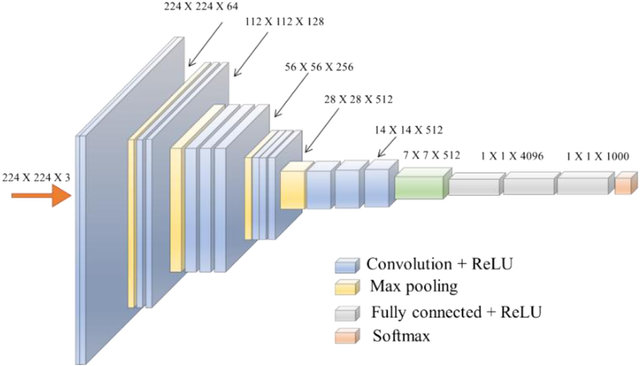

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
hist = model.fit(
    train_btch,
    epochs=20,
    validation_data=validation_btch,
    callbacks=callbacks,
    verbose=2)

In [ ]:
import matplotlib.pyplot as plt

loss = hist.history["loss"]
val_loss = hist.history["val_loss"]
acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]


epoch = range(1, len(acc) + 1)


plt.plot(epoch, loss, "--g", label="Training loss")
plt.plot(epoch, val_loss, "g", label="Validation loss")
plt.title("Loss")
plt.xlabel("epoch")
plt.legend()
plt.figure()

plt.plot(epoch, acc, "-r", label="Training accuracy")
plt.plot(epoch, val_acc, "r", label="Validation accuracy")
plt.title("Accuracy")
plt.xlabel("epoch")

plt.legend()
plt.figure()

plt.show()

OK, there is overfitting. But we will fix it, later :) . 

<a id ="pred"></a> 
<div class="alert alert-danger" role="alert">
 <font size=15 <b>  Predict </b> </font> </div>



In [ ]:
test_img, test_label = next(test_btch)
plotImg(test_img)
print(test_label)

In [ ]:
test_btch.classes

In [ ]:
predictions= model.predict(x=test_btch,verbose=0)

In [ ]:
np.round(predictions)

<a id ="cm"></a> 

<div class="alert alert-warning" role="alert">
 <font size=15 <b>  CONFUSION MATRIX </b> </font> 
</div>


In [ ]:
cm = confusion_matrix(y_true=test_btch.classes, y_pred=np.argmax(predictions,axis=-1))

# Argmax is most commonly used in machine learning for finding
# the class with the largest predicted probability. 
# [https://machinelearningmastery.com/argmax-in-machine-learning/]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# [https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html]

In [ ]:
test_btch.class_indices

In [ ]:
cm_labels = ["cat","dog"]
plot_confusion_matrix(cm=cm,classes = cm_labels, title = "CM")

64+69 = 133


31+36 = 67 

<a id ="fine"></a> 

<div class="alert alert-danger" role="alert">
<font size=15 <b>  FINE-TUNING </b> </font>  
</div>


In [ ]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [ ]:
vgg16_model.summary()

In [ ]:
from keras.models import Model

model = Sequential()

for layer in vgg16_model.layers[:-1]:
    model.add(layer)
    


In [ ]:
model.summary()

In [ ]:
for layer in model.layers:
    layer.trainable = False
model.add(Dense(2, activation="softmax"))

In [ ]:
model.summary()

In [ ]:

model.compile(loss="categorical_crossentropy",optimizer=optimizers.RMSprop(lr=1e-3),
              metrics=["accuracy"])

In [ ]:
model.fit(x=train_btch,validation_data=validation_btch, epochs=5, verbose=2)

<a id ="after"></a> 

<div class="alert alert-success" role="alert">
  <font size=15 <b>  PREDICT AFTER FINE TUNING  </b> </font>  
</div>

In [ ]:
predictions =model.predict(x=test_btch,verbose=0)

In [ ]:
test_btch.classes

In [ ]:
cm = confusion_matrix(y_true=test_btch.classes, y_pred=np.argmax(predictions,axis=-1))


In [ ]:
test_btch.class_indices

<a id ="SON"></a> 
<div class="alert alert-success" role="alert">
  <font size=15 <b>  RESULT </b> </font>  
</div>

In [ ]:
cm_labels = ["cat","dog"]
plot_confusion_matrix(cm=cm,classes = cm_labels, title = "CM after fine tuning")

JUST 7! :)) 

97+96/200= 0.965 ACC RATE.

**I welcome your comments for any corrections and improvements.**

**Thanks**!